__Probing Language Models__

This notebook serves as a start for your NLP2 assignment on probing Language Models. This notebook will become part of the contents that you will submit at the end, so make sure to keep your code (somewhat) clean :-)

__note__: This is the first time _anyone_ is doing this assignment. That's exciting! But it might well be the case that certain aspects are too unclear. Do not hesitate at all to reach to me once you get stuck, I'd be grateful to help you out.

__note 2__: This assignment is not dependent on big fancy GPUs. I run all this stuff on my own 3 year old CPU, without any Colab hassle. So it's up to you to decide how you want to run it.

# Models

For the Transformer models you are advised to make use of the `transformers` library of Huggingface: https://github.com/huggingface/transformers
Their library is well documented, and they provide great tools to easily load in pre-trained models.

In [66]:
import torch.nn as nn

In [118]:
# Custom Configuration|
from config import Config

config: Config = Config(
    run_label='full_data',
    uses_sample=False,
    path_to_data_train='data/en_ewt-ud-train.conllu',
    path_to_data_valid='data/en_ewt-ud-dev.conllu',
    feature_model_type='LSTM',
    will_train_simple_probe=True,
    will_control_task_simple_prob=False,
    will_train_structural_probe=False,
    will_train_dependency_probe=True,
    will_control_task_dependency_probe=True,
    struct_probe_train_epoch=100,
    dep_probe_train_epoch=1000,
    struct_probe_lr=0.001
)

In [85]:
# We first load our feature models
from models.model_inits import make_pretrained_lstm_and_tokenizer

# The Gulordava LSTM model can be found here:
# https://drive.google.com/open?id=1w47WsZcZzPyBKDn83cMNd0Hb336e-_Sy

# Initializing the LSTM
lstm, lstm_vocab = make_pretrained_lstm_and_tokenizer()

# Initializing the Transformer
trans_model_type: str = config.feature_model_type if config.feature_model_type is not 'LSTM' else config.default_trans_model_type
trans_model = GPT2Model.from_pretrained(trans_model_type)
trans_tokenizer = GPT2Tokenizer.from_pretrained(trans_model_type)

# Data

For this assignment you will train your probes on __treebank__ corpora. A treebank is a corpus that has been *parsed*, and stored in a representation that allows the parse tree to be recovered. Next to a parse tree, treebanks also often contain information about part-of-speech tags, which is exactly what we are after now.

The treebank you will use for now is part of the Universal Dependencies project. I provide a sample of this treebank as well, so you can test your setup on that before moving on to larger amounts of data.

Make sure you accustom yourself to the format that is created by the `conllu` library that parses the treebank files before moving on. For example, make sure you understand how you can access the pos tag of a token, or how to cope with the tree structure that is formed using the `to_tree()` functionality.

In [79]:
from typing import Callable, Dict, List, Optional, Union
from conllu import parse_incr, TokenList
from data_tools.data_inits import parse_corpus

In [45]:
# 🏁
# Some utility data-elements for reference
sample_corpus: List[TokenList] = parse_corpus('data/sample/en_ewt-ud-train.conllu')
sample_sents: List[TokenList] = sample_corpus[:1]
sample_sent: TokenList = sample_corpus[0]

In [46]:
# 🏁
# Utility functions for dealing with the conllu dataset
from typing import Callable

get_pos_from_sent: Callable[[TokenList], List[str]] = lambda sent: [word['upostag'] for word in sent]
get_tokens_from_sent: Callable[[TokenList], List[str]] = lambda sent: [word['form'] for word in sent]
get_ids_from_sent: Callable[[TokenList], List[str]] = lambda sent: [word['id'] for word in sent]

# Generating Representations

We now have our data all set, our models are running and we are good to go!

The next step is now to create the model representations for the sentences in our corpora. Once we have generated these representations we can store them, and train additional diagnostic (/probing) classifiers on top of the representations.

There are a few things you should keep in mind here. Read these carefully, as these tips will save you a lot of time in your implementation.
- Transformer models make use of Byte-Pair Encodings (BPE), that chunk up a piece of next in subword pieces. For example, a word such as "largely" could be chunked up into "large" and "ly". We are interested in probing linguistic information on the __word__-level. Therefore, we will follow the suggestion of Hewitt et al. (2019a, footnote 4), and create the representation of a word by averaging over the representations of its subwords. So the representation of "largely" becomes the average of that of "large" and "ly".

- Subword chunks never overlap multiple tokens. In other words, say we have a phrase like "None of the", then the tokenizer might chunk that into "No"+"ne"+" of"+" the", but __not__ into "No"+"ne o"+"f the", as those chunks overlap multiple tokens. This is great for our setup! Otherwise it would have been quite challenging to distribute the representation of a subword over the 2 tokens it belongs to.

- If you closely examine the provided treebank, you will notice that some tokens are split up into multiple pieces, that each have their own POS-tag. For example, in the first sentence the word "Al-Zaman" is split into "Al", "-", and "Zaman". In such cases, the conllu `TokenList` format will add the following attribute: `('misc', OrderedDict([('SpaceAfter', 'No')]))` to these tokens. Your model's tokenizer does not need to adhere to the same tokenization. E.g., "Al-Zaman" could be split into "Al-"+"Za"+"man", making it hard to match the representations with their correct pos-tag. Therefore I recommend you to not tokenize your entire sentence at once, but to do this based on the chunking of the treebank. Make sure to still incoporate the spaces in a sentence though, as these are part of the BPE of the tokenizer. The tokenizer for GPT-2 adds spaces at the start of a token.

- The LSTM LM does not have the issues related to subwords, but is far more restricted in its vocabulary. Make sure you keep the above points in mind though, when creating the LSTM representations. You might want to write separate functions for the LSTM, but that is up to you.

I would like to stress that if you feel hindered in any way by the simple code structure that is presented here, you are free to modify it :-) Just make sure it is clear to an outsider what you're doing, some helpful comments never hurt.

In [81]:
# FETCH SENTENCE REPRESENTATIONS
from torch import Tensor
import pickle
from data_tools.feature_extractors import fetch_sen_reps

# A sanity check was provided by the supervisor of this project, to compare representations with a 'gold standard'.
def assert_sen_reps(transformer_model, transformer_tokenizer, lstm_model, lstm_tokenizer):
    with open('lstm_emb1.pickle', 'rb') as f:
        lstm_emb1: torch.Tensor = pickle.load(f)
    with open('distilgpt2_emb1.pickle', 'rb') as f:
        distilgpt2_emb1: torch.Tensor = pickle.load(f)

    corpus = parse_corpus('data/sample/en_ewt-ud-train.conllu')

    own_gpt2_emb1: torch.Tensor = fetch_sen_reps(corpus, transformer_model, transformer_tokenizer)[0]
    own_lstm_emb1: torch.Tensor = fetch_sen_reps(corpus, lstm_model, lstm_tokenizer)[0]

    assert distilgpt2_emb1.shape == own_gpt2_emb1.shape, "GPT2 Shapes don't match!"
    assert lstm_emb1.shape == own_lstm_emb1.shape, "LSTM Shapes don't match!"

    assert torch.allclose(distilgpt2_emb1, own_gpt2_emb1, atol=1e-04), "GPT2 Embeddings don't match!"
    assert torch.allclose(lstm_emb1, own_lstm_emb1, atol=1e-04), "LSTM Embeddings don't match!"

    print('Passed basic checks!')

assert_sen_reps(trans_model, trans_tokenizer, lstm, vocab)

Passed basic checks!


In [49]:
# 🏁
from typing import Tuple

def fetch_pos_tags(ud_parses: List[TokenList],
                    pos_vocab: Optional[DefaultDict[str, int]] = None,
                    corrupted=False,
                    corrupted_pos_tags: Optional[Dict[str, str]] = None)-> Tuple[List[Tensor], DefaultDict]:
    """
    Converts `ud_parses` into a tensor of POS tags.
    """
    # If `pos_vocab` is not known, make one based on all POS tokens in `ud_parses`
    if (pos_vocab is None):
        print('get all tokens')
        all_pos_tokens = set([pos for sent in ud_parses for pos in get_pos_from_sent(sent)])
        print('get all pos2i')
        pos2i = {'<pad>': 0, '<unk>': 1, **{pos.strip(): i + 2 for i, pos in enumerate(all_pos_tokens)}}
        pos_vocab = defaultdict(lambda: pos2i["<unk>"])
        pos_vocab.update(pos2i)
    pos_tokens_result: List[Tensor] = []

    sent: TokenList

    for sent in ud_parses:
        # If corrupted, let the target value be the corrupted tokens
        if corrupted:
            pos_tokens = torch.tensor([pos_vocab[corrupted_pos_tags[word]] for word in get_tokens_from_sent(sent)])
        else:
            pos_tokens = torch.tensor([pos_vocab[pos] for pos in get_pos_from_sent(sent)])
        pos_tokens_result.append(pos_tokens)


    return pos_tokens_result, pos_vocab

In [86]:
import os
import itertools
from collections import Counter

# Here we decide which language model to use `lm`,
if config.feature_model_type == 'LSTM':
    print("Important: We will use LSTM as our model representation")
    model = lstm
    model_name = 'LSTM'
    config.feature_model_dimensionality = 650
    w2i = vocab
else:
    print(f"Important: We will use {config.feature_model_type} as our model representation")
    config.feature_model_dimensionality = 768
    model = trans_model
    w2i = trans_tokenizer

use_sample = config.uses_sample

# Function that combines the previous functions, and creates 2 tensors for a .conllu file:
# 1 containing the token representations, and 1 containing the (tokenized) pos_tags.

def create_data(
    filename: str,
    model,
    w2i: Dict[str, int],
    pos_vocab=None,
    corrupted=False,
    corrupted_pos_tags: Optional[Dict[str, str]] = None
):
    print('Parsing the corpus')
    ud_parses = parse_corpus(filename)

    print('Fetching the POS tags')
    pos_tags, pos_vocab = fetch_pos_tags(ud_parses,
                                            pos_vocab=pos_vocab,
                                            corrupted=corrupted,
                                            corrupted_pos_tags=corrupted_pos_tags)
    print(f'Fetching sen reps using {type(model).__name__} in `create_data`')
    sen_reps = fetch_sen_reps(ud_parses, model, w2i)


    return sen_reps, pos_tags, pos_vocab

Important: We will use LSTM as our model representation


In [87]:
# Create Corrupted Data
from torch.distributions import Categorical

def create_corrupted_tokens(use_sample: bool) -> Dict[str, str]:
    # Get sentences from all data sets
    ud_parses = []
    for set_type in ['train', 'dev', 'test']:
        filename = os.path.join('data', 'sample' if use_sample else '', f'en_ewt-ud-{set_type}.conllu')

        ud_parses += (parse_corpus(filename))

    all_pos_tokens = list(set([pos for sent in ud_parses for pos in get_pos_from_sent(sent)]))
    all_pos_tokens = ['<pad>', '<unk>', *all_pos_tokens]

    possible_targets_distr = Categorical(torch.tensor([1/len(all_pos_tokens) for _ in range(len(all_pos_tokens))]))

    corrupted_word_type: DefaultDict[str, str] = defaultdict(lambda: "UNK")
    # Get a corrupted POS tag for each word
    for sentence in ud_parses:
        for token in sentence:

            corrupted_pos_tag = all_pos_tokens[possible_targets_distr.sample()]

            if token['form'] not in corrupted_word_type:
                corrupted_word_type[token['form']] = corrupted_pos_tag

    return corrupted_word_type

 # Get out corrupted pos tokens for each word type
corrupted_pos_tags: Dict[str, str] = create_corrupted_tokens(use_sample)

In [52]:
# Utility functions for transforming X and y to appropriate formats
def transform_XY_to_concat_tensors(X: List[Tensor], y: List[Tensor]) -> Tuple[Tensor, Tensor]:
    # X_concat = torch.cat([x.reshape(1) for x in X], dim=0)
    X_concat = torch.cat(X, dim=0)
    y_concat = torch.cat(y, dim=0)

    return X_concat, y_concat

def transform_XY_to_padded_tensors(X: List[Tensor], y: List[Tensor]) -> Tuple[Tensor, Tensor]:
    X_padded = pad_sequence(X)
    y_padded = pad_sequence(y)

    return X_padded, y_padded

# Diagnostic Classification

We now have our models, our data, _and_ our representations all set! Hurray, well done. We can finally move onto the cool stuff, i.e. training the diagnostic classifiers (DCs).

DCs are simple in their complexity on purpose. To read more about why this is the case you could already have a look at the "Designing and Interpreting Probes with Control Tasks" by Hewitt and Liang (esp. Sec. 3.2).

A simple linear classifier will suffice for now, don't bother with adding fancy non-linearities to it.

I am personally a fan of the `skorch` library, that provides `sklearn`-like functionalities for training `torch` models, but you are free to train your dc using whatever method you prefer.

As this is an Artificial Intelligence master and you have all done ML1 + DL, I expect you to use your train/dev/test splits correctly ;-)

In [57]:
# DIAGNOSTIC CLASSIFIER
# 🏁
%reload_ext autoreload
%autoreload 2
from models.probes import SimpleProbe

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, Checkpoint, TrainEndCheckpoint, LoadInitState, EarlyStopping
from skorch.dataset import Dataset
from skorch.helper import predefined_split
from skorch.history import History

from tools.results_writer import ResultsWriter

rw = ResultsWriter(config)

# Helper function to calculate accuracy
accuracy = lambda preds, targets: sum([1 if pred == target else 0 for pred, target in zip(preds, targets)]) / len(preds)
pos_probe_results = defaultdict(list)
valid_acc = None
train_acc = EpochScoring(scoring='accuracy',
                        on_train=True,
                        name='train_acc',
                        lower_is_better=False)
early_stopping = EarlyStopping(monitor='valid_acc',
                                patience=config.pos_probe_train_patience,
                                lower_is_better=False)
callbacks = [train_acc, early_stopping]

if config.will_train_simple_probe:
    train_data_X, train_data_y, train_vocab = create_data(
        os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-train.conllu'),
        model,
        w2i
    )

    valid_data_X, valid_data_y, _ = create_data(
        os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-dev.conllu'),
        model,
        w2i,
        pos_vocab=train_vocab
    )

    train_X, train_y = transform_XY_to_concat_tensors(train_data_X, train_data_y)
    valid_X, valid_y = transform_XY_to_concat_tensors(valid_data_X, valid_data_y)
    valid_ds = Dataset(valid_X, valid_y)

    print('Training POS probe')
    train_acc = EpochScoring(scoring='accuracy',
                            on_train=True,
                            name='train_acc',
                            lower_is_better=False)
    early_stopping = EarlyStopping(monitor='valid_acc',
                                    patience=config.pos_probe_train_patience,
                                    lower_is_better=False)
    callbacks = [train_acc, early_stopping]

    embedding_size = train_data_X[0].shape[1] # size of the word embedding (either 650 or 768)
    vocab_size = len(train_vocab)#17

    probe: nn.Module = SimpleProbe(
        embedding_size,
        vocab_size
    )

    net: NeuralNetClassifier = NeuralNetClassifier(
        probe,
        callbacks=callbacks,
        max_epochs=config.pos_probe_train_epoch,
        batch_size=config.pos_probe_train_batch_size,
        lr=config.pos_probe_train_lr,
        train_split=predefined_split(valid_ds),
        iterator_train__shuffle=True,
        optimizer= torch.optim.Adam,
    )

    net.fit(train_X, train_y)
    print('Done Training Probe')

    # Get accuracy score
    valid_predictions = net.predict(valid_X)
    valid_acc = accuracy(valid_predictions, valid_y)
    print(f'Validation Accuracy: {valid_acc:.4f}')

    # Get validation losses / accuracies from skorch's history
    net_history = net.history
    validation_losses = net_history[:,'valid_loss']
    validation_accs = net_history[:, 'valid_acc']
    pos_probe_results['validation_losses'] = validation_losses
    pos_probe_results['validation_accs'] = validation_accs

Parsing the corpus
Fetching the POS tags
get all tokens
get all pos2i
Fetching sen reps using RNNModel in `create_data`
Parsing the corpus
Fetching the POS tags
Fetching sen reps using RNNModel in `create_data`
Training POS probe
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.7539        1.2302       0.8186        0.7120  5.1824
      2       0.8481        0.5730       0.8471        0.5386  4.7088
      3       0.8691        0.4670       0.8605        0.4788  5.0986
      4       0.8796        0.4208       0.8679        0.4479  5.0005
      5       0.8860        0.3938       0.8720        0.4286  4.9894
      6       0.8900        0.3756       0.8748        0.4151  5.0663
      7       0.8927        0.3625       0.8766        0.4055  4.9720
      8       0.8948        0.3524       0.8778        0.3979  4.9013
      9       0.8968        0.3445       0.8790        0.3920  4.3231


In [34]:
if config.will_control_task_simple_prob:
    corrupted_train_data_X, corrupted_train_data_y, corrupted_train_vocab = create_data(
        os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-train.conllu'),
        model,
        w2i,
        corrupted=True,
        corrupted_pos_tags=corrupted_pos_tags
    )

    corrupted_valid_data_X, corrupted_valid_data_y, _ = create_data(
        os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-train.conllu'),
        model,
        w2i,
        pos_vocab=corrupted_train_vocab,
        corrupted=True,
        corrupted_pos_tags=corrupted_pos_tags
    )

    embedding_size = corrupted_train_data_X[0].shape[1] # size of the word embedding (either 650 or 768)
    vocab_size = len(corrupted_train_vocab)#17

    probe: nn.Module = SimpleProbe(
        embedding_size,
        vocab_size
    )

    corrupted_train_X, corrupted_train_y = transform_XY_to_concat_tensors(corrupted_train_data_X, corrupted_train_data_y)
    corrupted_valid_X, corrupted_valid_y = transform_XY_to_concat_tensors(corrupted_valid_data_X, corrupted_valid_data_y)
    corrupted_valid_ds = Dataset(corrupted_valid_X, corrupted_valid_y)

    corrupted_probe: nn.Module = SimpleProbe(
        embedding_size,
        vocab_size
    )

    corrupted_net: NeuralNetClassifier = NeuralNetClassifier(
        probe,
        callbacks=callbacks,
        max_epochs=config.pos_probe_train_epoch,
        batch_size=config.pos_probe_train_batch_size,
        lr=config.pos_probe_train_lr,
        train_split=predefined_split(corrupted_valid_ds),
        iterator_train__shuffle=True,
        optimizer= torch.optim.Adam,
    )

    corrupted_net.fit(corrupted_train_X, corrupted_train_y)

    corrupted_valid_preds = corrupted_net.predict(corrupted_valid_X)
    corrupted_valid_acc = accuracy(corrupted_valid_preds, corrupted_valid_y)
    print(f'Corrupted Validation Accuracy: {corrupted_valid_acc:.4f}')
    corrupted_total_epochs = len(corrupted_net.history)

    if valid_acc is not None:
        valid_selectivity = valid_acc - corrupted_valid_acc
        print(f'Validation Selectivity: {valid_selectivity:.4f}')

    corrupted_history = corrupted_net.history
    corrupted_validation_losses = corrupted_history[:,'valid_loss']
    corrupted_validation_accs = corrupted_history[:,'valid_acc']
    pos_probe_results['corrupted_validation_losses'] = corrupted_validation_losses
    pos_probe_results['corrupted_validation_accs'] = corrupted_validation_accs

# Now write results at the end of the POS
if config.will_train_simple_probe or config.will_control_task_simple_prob:
    rw.write_results('POS', 'Transformer', config.feature_model_type, results=pos_probe_results)

Probably cant read file Transformer.csv
Probably cant read the LSTM.csv


Text(0, 0.5, 'accuracy')

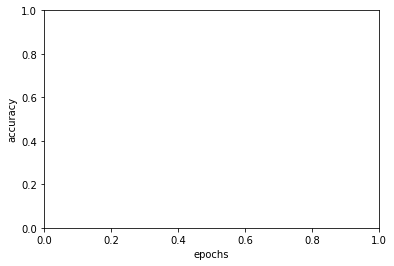

In [35]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

try:
    trans_result_df = pd.read_csv('results/POS_probe/Transformer.csv')
    trans_result_df = trans_result_df.rename(columns={'validation_accs':'Trans Val Accs', 'c_validation_accs':'Corr Trans Val Accs'})
    ax1 = sns.lineplot(data=trans_result_df[['Trans Val Accs', 'Corr Trans Val Accs']], alpha=0.7)
except:
    print("Probably cant read file Transformer.csv")

try:
    lstm_result_df = pd.read_csv('results/POS_probe/LSTM.csv')
    lstm_result_df = lstm_result_df.rename(columns={'validation_accs':'LSTM Val Accs', 'c_validation_accs':'Corr LSTM Val Accs'})
    ax2 = sns.lineplot(data=lstm_result_df[['LSTM Val Accs', 'Corr LSTM Val Accs']], alpha=0.7)
except:
    print("Probably cant read the LSTM.csv")

sns.set_palette(sns.color_palette("BuGn_r"))
sns.set_palette(sns.light_palette("navy", reverse=True))

plt.xlabel('epochs')
plt.ylabel('accuracy')

In [36]:

def plot_probe_validation_accs(filename: str, model_type: str, column_names:dict):
    assert model_type in ['POS', 'Edge', 'Structural'], 'model type needs to be: POS, Edge or Structural.'
    assert 'val_accs_column' in column_names, 'Missing key(val_accs_column):value(...)'
    assert 'corrupted_val_accs_column' in column_names, 'Missing key(corrupted_val_accs_column):value(...)'

    transformer_df = pd.read_csv(f'results/{model_type}/trans_{filename}.csv')
    transformer_df = transformer_df.rename(columns={column_names['val_accs_column']:'Trans Val Accs', [column_names[1]]:'Corr Trans Val Accs'})

    lstm_df = pd.read_csv(f'results/{model_type}/lstm_{filename}.csv')
    lstm_df = lstm_df.rename(columns={column_names['corrupted_val_accs_column']:'LSTM Val Accs', [column_names[1]]:'LSTM Trans Val Accs'})

    sns.set_palette(sns.color_palette("BuGn_r"))
    ax1 = sns.lineplot(data=trans_result_df[['Trans Val Accs', 'Corr Trans Val Accs']], alpha=0.7)
    sns.set_palette(sns.light_palette("navy", reverse=True))
    ax2 = sns.lineplot(data=lstm_result_df[['LSTM Val Accs', 'Corr LSTM Val Accs']], alpha=0.7)


    plt.xlabel('epochs')
    plt.ylabel('accuracy')

def plot_probe_validation_accs_by_modelfiles(filename_LSTM: str, filename_Transformer, probe_type: str):
    assert probe_type in ['POS', 'dep_edge_probe', 'struct_probe'], 'model type needs to be: POS, Edge or Structural.'
    transformer_df = pd.read_csv(filename_Transformer)
    lstm_df = pd.read_csv(filename_LSTM)

    sns.set_palette(sns.color_palette("BuGn_r"))
    # ax1 = sns.lineplot(data=transfo[['Trans Val Accs', 'Corr Trans Val Accs']], alpha=0.7)

    sns.set_palette(sns.light_palette("navy", reverse=True))
    ax2 = sns.lineplot(data=lstm_result_df[['LSTM Val Accs', 'Corr LSTM Val Accs']], alpha=0.7)


    plt.xlabel('epochs')
    plt.ylabel('accuracy')

# Trees

For our gold labels, we need to recover the node distances from our parse tree. For this we will use the functionality provided by `ete3`, that allows us to compute that directly. I have provided code that transforms a `TokenTree` to a `Tree` in `ete3` format.

In [70]:
from tools.tree_tools import tokentree_to_ete, tokentree_to_nltk, edges, create_mst



As you can see we label a token by its token id (converted to a string). Based on these id's we are going to retrieve the node distances.

To create the true distances of a parse tree in our treebank, we are going to use the `.get_distance` method that is provided by `ete3`: http://etetoolkit.org/docs/latest/tutorial/tutorial_trees.html#working-with-branch-distances

We will store all these distances in a `torch.Tensor`.

The next step is now to do the previous step the other way around. After all, we are mainly interested in predicting the node distances of a sentence, in order to recreate the corresponding parse tree.

Hewitt et al. reconstruct a parse tree based on a _minimum spanning tree_ (MST, https://en.wikipedia.org/wiki/Minimum_spanning_tree). Fortunately for us, we can simply import a method from `scipy` that retrieves this MST.

Let's have a look at what this looks like, by looking at a relatively short sentence in the sample corpus.

If your addition to the `create_gold_distances` method has been correct, you should be able to run the following snippet. This then shows you the original parse tree, the distances between the nodes, and the MST that is retrieved from these distances. Can you spot the edges in the MST matrix that correspond to the edges in the parse tree?

In [78]:
# Read corpus,
corpus = parse_corpus(config.path_to_data_train)
sample_sent = corpus[5]

# Convert sentence to tree
sample_tokentree = sample_sent.to_tree()
sample_ete3_tree = tokentree_to_ete(sample_tokentree)
print(ete3_tree, '\n')

# Extract gold-distance from sentence
sample_gold_distance = create_struct_gold_distances([sample_sent])[0]
print(gold_distance, '\n')

# Transform gold-distance to minimum spanning tree
sample_mst = create_mst(sample_gold_distance)
print(sample_mst)


   /2 /-1
  |
  |--3
  |
  |--4
  |
  |   /-6
  |  |
-5|  |--7
  |-8|
  |  |   /-9
  |  |  |
  |   \12--10
  |     |
  |      \-11
  |
   \-13 

tensor([[0., 1., 3., 3., 2., 4., 4., 3., 5., 5., 5., 4., 3.],
        [1., 0., 2., 2., 1., 3., 3., 2., 4., 4., 4., 3., 2.],
        [3., 2., 0., 2., 1., 3., 3., 2., 4., 4., 4., 3., 2.],
        [3., 2., 2., 0., 1., 3., 3., 2., 4., 4., 4., 3., 2.],
        [2., 1., 1., 1., 0., 2., 2., 1., 3., 3., 3., 2., 1.],
        [4., 3., 3., 3., 2., 0., 2., 1., 3., 3., 3., 2., 3.],
        [4., 3., 3., 3., 2., 2., 0., 1., 3., 3., 3., 2., 3.],
        [3., 2., 2., 2., 1., 1., 1., 0., 2., 2., 2., 1., 2.],
        [5., 4., 4., 4., 3., 3., 3., 2., 0., 2., 2., 1., 4.],
        [5., 4., 4., 4., 3., 3., 3., 2., 2., 0., 2., 1., 4.],
        [5., 4., 4., 4., 3., 3., 3., 2., 2., 2., 0., 1., 4.],
        [4., 3., 3., 3., 2., 2., 2., 1., 1., 1., 1., 0., 3.],
        [3., 2., 2., 2., 1., 3., 3., 2., 4., 4., 4., 3., 0.]]) 

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0

Now that we are able to map edge distances back to parse trees, we can create code for our quantitative evaluation. For this we will use the Undirected Unlabeled Attachment Score (UUAS), which is expressed as:

$$\frac{\text{number of predicted edges that are an edge in the gold parse tree}}{\text{number of edges in the gold parse tree}}$$

To do this, we will need to obtain all the edges from our MST matrix. Note that, since we are using undirected trees, that an edge can be expressed in 2 ways: an edge between node $i$ and node $j$ is denoted by both `mst[i,j] = 1`, or `mst[j,i] = 1`.

You will write code that computes the UUAS score for a matrix of predicted distances, and the corresponding gold distances. I recommend you to split this up into 2 methods: 1 that retrieves the edges that are present in an MST matrix, and one general method that computes the UUAS score.

# Structural Probes

We will now train the structural probe. The Probing model used is founded on John Hewitt's source code.

For this task, we will make use of the `train_struct` function as main training loop, located in `runners/trainers`. Furthermore, the `make_struct_dataloaders` will initialize the dataloaders with the features again as X, and correct edge distances as `y`.

In [67]:
from data_tools.datasets import ProbingDataset
import numpy as np

In [ ]:
from runners.trainers import train_struct
from models.model_inits import make_pretrained_lstm_and_tokenizer, make_pretrained_transformer_and_tokenizer
from data_tools.dataloaders import make_struct_dataloaders

# We will train the structural probe if `config.will_train_structural_probe` allows it.
if config.will_train_structural_probe:
    print("Loading in data for structural probe!")
    train_dataloader, valid_dataloader = make_struct_dataloaders(
        path_to_train=config.path_to_data_train,
        path_to_valid=config.path_to_data_valid,
        feature_model=model,
        feature_model_tokenizer=w2i,
    )

    probe, losses, uuas = train_struct(
        train_dataloader,
        valid_dataloader,
        nr_epochs=config.struct_probe_train_epoch,
        struct_emb_dim=embedding_size,
        struct_lr=config.struct_probe_lr,
        struct_rank=config.struct_probe_rank,
    )

    struct_probe_results = {
        'probe_valid_losses': losses,
        'probe_valid_uuas_scores': uuas
    }

    rw.write_results('struct', config.feature_model_type, '', struct_probe_results)

# Dependency Probing Parent Task

In this part of the experimental setup, a different will be considered. To prevent any wrong conclusions based on ill-conceived ideas of control tasks for control tasks, a new task will be considered for this specific purpose. Based on John Hewitt and Percy Liang's work on 'Designing and Interpreting Probes with Control Tasks', this next task will consider a different the task of finding a node's parent, instead of finding all edges.

This will be treated like a classificiation task, where given N potential nodes, the goal is to predict which of the N nodes is the parent, with Negative Log Likelihood as main loss function.

In [114]:
# Initialize results for which we might want to write something
dep_probe_results = defaultdict(list)

if config.will_train_dependency_probe:
    print("Loading datasets for Dependency parsing")
    train_dataloader, valid_dataloader = make_struct_dataloaders(
        config.path_to_data_train,
        config.path_to_data_valid,
        feature_model=model,
        feature_model_tokenizer=w2i,
        use_dependencies=True
    )

    print("Starting training for Dependency parsing")
    dep_trained_probe, dep_valid_losses, dep_valid_acc = train_dep_parsing(
        train_dataloader,
        valid_dataloader,
        feature_dim=config.feature_model_dimensionality,
        probe_rank=config.dep_probe_rank,
        lr=config.dep_probe_lr,
        nr_epochs=config.dep_probe_train_epoch
    )

    # We then store some results
    dep_probe_results['valid_losses'] = dep_valid_losses
    dep_probe_results['valid_acc'] = dep_valid_acc

Loading datasets for Dependency parsing
Starting training for Dependency parsing

---- EPOCH 1 ---- 

Encountered: null sentence at idx 3
Average evaluation loss score is 2.606781244277954
Average evaluation accuracy score is 0.3054361939430237
New loss has been reached of 2.606781244277954 being lower than lowest_loss inf

---- EPOCH 2 ---- 

Encountered: null sentence at idx 3
Average evaluation loss score is 2.155669927597046
Average evaluation accuracy score is 0.31256192922592163
New loss has been reached of 2.155669927597046 being lower than lowest_loss 2.606781244277954

---- EPOCH 3 ---- 

Encountered: null sentence at idx 3
Average evaluation loss score is 1.9864505529403687
Average evaluation accuracy score is 0.351388156414032
New loss has been reached of 1.9864505529403687 being lower than lowest_loss 2.155669927597046

---- EPOCH 4 ---- 

Encountered: null sentence at idx 3
Average evaluation loss score is 1.8776729106903076
Average evaluation accuracy score is 0.382662326

In [119]:
from data_tools.data_inits import parse_all_corpora
from runners.trainers import train_dep_parsing

# Control task time
if config.will_control_task_dependency_probe:
    # Read all corpora and make a vocab for how to deal with all possible tokens
    all_corpora = parse_all_corpora(True)
    corrupted_dep_vocab = create_corrupted_dep_vocab(all_corpora)

    print("Loading datasets for Dependency Probes - Control Task")
    train_dataloader, valid_dataloader = make_struct_dataloaders(
        config.path_to_data_train,
        config.path_to_data_valid,
        feature_model=model,
        feature_model_tokenizer=w2i,
        use_dependencies=True,
        use_corrupted=True,
        corrupted_vocab=corrupted_dep_vocab
    )

    print("Starting training for Dependency parsing - Control Task")
    dep_trained_probe, dep_valid_losses, dep_valid_acc = train_dep_parsing(
        train_dataloader,
        valid_dataloader,
        feature_dim=config.feature_model_dimensionality,
        probe_rank=config.dep_probe_rank,
        lr=config.dep_probe_lr,
        nr_epochs=config.dep_probe_train_epoch,
    )

    dep_probe_results['corrupted_valid_losses'] = corrupted_dep_valid_losses
    dep_probe_results['corrupted_dep_valid_acc'] = corrupted_dep_valid_acc

if config.will_control_task_dependency_probe or config.will_train_dependency_probe:
    rw.write_results('dep_edge', config.feature_model_type, '', dep_probe_results)

Loading datasets for Dependency Probes - Control Task


TypeError: list indices must be integers or slices, not str